# How to Price Your Home
## A data exploration, modeling and evaluation using the Ames, Iowa housing sales dataset

### Overview

- Initial exploration
    - Exploration of the target variable
- Data preparation
- Modeling
    - Model-less baseline
    - Multiple linear regression
    - Ridge regression
- Discussion of next steps


Selling a home can be a torturous process. Homeowners rely on real estate agent's opinions and experience to guide them to the right decisions. So many questions haunt the homeowner. Are you pricing it right for the market? Are you pricing it to move quickly or get the maximum price?

My project aims to predict the sale price of houses using the [Ames, Iowa housing dataset](http://jse.amstat.org/v19n3/decock.pdf) produced by Dean De Cook, of Truman University in 2011. The training dataset used for this anaylsis was sourced from the [Advanced Regression Techniques Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). 

I began with a baseline that predicts only the mean house price from the training data for each house, but this model does very poorly (of course). My final model is a Ridge regression model, which had an R2 Score of 0.78 and a MAE of $24,244.

### Data Overview

The subset of the Ames, Iowa dataset includes 1,460 home sales and record 81 variables for each home. The variables describe the details of the home, its ammenities, the lot, the zoning, and descriptors of the type of sale itself. While many variables are not within the control of the homeowner, such as lot size or zoning, including them in the eventual model will be useful for controlling for the impact. 

A [full description of the original variables](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt) in the dataset is available. The final version of the dataset _before_ train-test-split has 1,294 observations and 41 numeric variables.

For this introductory analysis, I converted many variables to binary encoding, including some variables that were discrete, such as "number of fireplaces" became "Has Fireplace". A few categorical variables, rather than being one hot encoded into numerous binary columns, were reduced downn to the most popular category vs not. For  example, the categorical variable "electrical" was converted to is the house has a switch board breaker box vs anything  else. 

Future analysis  will include expanding the feature  set to include  more of the categorical variables.

The resulting dataset is a mixture of continuous, ordinal, and binary variables with no missing observations. 

In [2]:
# Imports
import pandas as pd
import numpy as np

# Custom code
import code.data_prep_code as dpc

# Visalization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Preparation and Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Feature importance library
import eli5
from eli5.sklearn import PermutationImportance

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Data Descisions

**Removed Observations**

I used the variable `SaleType`, to exclude new construction and estate trasfers from the analysis. I assumed that homeowners most interested in this analysis would be currently living _in_ their home and looking to sell. I then dropped the variable. Removing those home sales reduced the dataset to 1,295 observations. One house was also removed because it did not have electricity.

**Removed Variables**

- `Id` was removed, as it is a house identifier and not descriptive. 
- `FireplaceQu` was removed because the majority of houes do not have fireplaces. 
- `MiscFeature` was removed because there were so few misc features in the dataset. Sheds, second garages, and such counted as misc features.
- All variables that assessed the quality or condition of a _specific part of the house_ were dropped. Only Overall Condition and Overall Quality were retained. I mad this choice because the Overall variables are composits of the individual. If housing condition proves to be an important variable, later analysis can examine how the quality of individual rooms interact with overall quality and impact the final sale. 

**New  Variables**

- `Alley`: Only 91 homes in the dataset were listed to have `Alley`s behind the house, and the values for that variable were "gravel", "paved", or missing. I created a new variable to just capture **if** the property was adjacent to the property and drop the original alley type variable.
- `HasPool`: There are only 6 pools in the dataset. I dropped `PoolQC` and transformed `PoolArea` into `HasPool`
- `HasFireplace`: reduced `Fireplaces`, which is a count of fireplaces in the home, to a binary yes/no if the home has a fireplace at all.
- `HasFence`: reduced `Fence`, a list of fence condition descriptors, to a binary yes/no if the home came with a fence.
- `HasGarage`: if `GarageArea` equals zero, then the property has no garage. It also explains why some observations have missing variables for garage attributes. Upon investigation, those observations have zero garage area. 
- `GarageAreaPerCar`: `GarageArea` divided by `GarageCars`. With this created I could then drop `GarageArea`. It's assumed that the more cars, the larger the garage, so I did not want both variables in there violating regression assumptions. Having the ratio will control for multi-car garages that actually have very little space.
- `BsmtPerFinished`: The percent of the basement that is finished
- `HasCentralAir`: When CentralAir equals "Yes"
- `GasAirHeat`: Is set to 1 when the house uses a Gas forced warm air furnace for heating
- `SBboxElectric`: Is set to 1 when Standard Circuit Breakers & Romex is how the electrical is wired
- `HasDeck`: If the squarefootage of deck area is greater than 0
- `HasRemod`: If a renovation happened at all in house history
- `HouseAge`: They age of the house at time of sale
- `TimeSinceRemodel`: The years since the remodel
- `RemodFiveYrs`:  If the remodel happened within the 5 years prior to the sale
- `GaragebuiltWHouse`: Was the garage built at the same time as the house or later

**Fill NAs**

`LotFrontage`: filled the missing values with 0. The variable measures the number of feet of street the property touches. 


In [63]:
df = pd.read_csv('data/train.csv')

In [64]:
df = dpc.address_nas(df)

In [65]:
df_final = df.select_dtypes(exclude='object')

In [67]:
# Evaluating the breakdown of each numeric column
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1294.0,57.751159,42.396828,20.0,20.000,50.000000,70.000000,190.0
LotFrontage,1294.0,55.865533,34.285307,0.0,40.000,60.000000,78.000000,313.0
LotArea,1294.0,10485.491499,10371.422824,1300.0,7500.000,9375.000000,11470.500000,215245.0
OverallQual,1294.0,5.976043,1.329729,1.0,5.000,6.000000,7.000000,10.0
OverallCond,1294.0,5.636012,1.148509,1.0,5.000,5.000000,6.000000,9.0
MasVnrArea,1294.0,93.699382,172.244583,0.0,0.000,0.000000,145.000000,1600.0
BsmtUnfSF,1294.0,531.792117,414.005734,0.0,207.250,448.000000,768.750000,2336.0
TotalBsmtSF,1294.0,1021.054096,401.208183,0.0,788.000,964.500000,1232.000000,3206.0
1stFlrSF,1294.0,1133.052550,355.946808,334.0,872.000,1057.500000,1339.750000,3228.0
2ndFlrSF,1294.0,350.793663,433.099395,0.0,0.000,0.000000,729.000000,2065.0


#### Explore Target Variable

The target variable shows that there are some outliers in the data, which are homes that were sold at much higher prices than most of the other homes in the dataset. I kept these outliers in, however may consider doing a transformation at some point to normalize the target variable. Alternatively, I could train my model without those outliers, with the understanding that then my model would only be accurate at homes that would be sold at prices less than a certain amount.

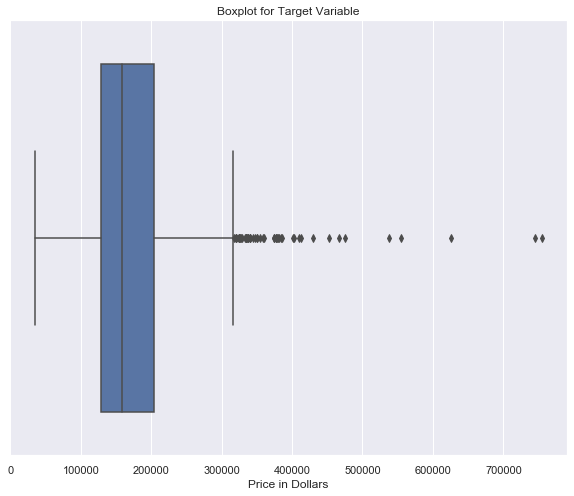

In [68]:
# plotting the distribution of the target variable with a boxplot
plt.figure(figsize=(10,8))
sns.boxplot(x=df_final['SalePrice'])
plt.title("Boxplot for Target Variable")
plt.xlabel("Price in Dollars")
plt.show()

In [ ]:
# plotting the correlation between variables and the target using a heatmap
plt.figure(figsize=(2,10))
sns.heatmap(df.corr()[['SalePrice']])
plt.title("Correlation of Each Independent Variable \n with the Target Variable \n")
plt.show()

The most correlated variable with the target is `OverallQual`, which captures the ranking of the Overall Quality of a home

In [ ]:
test = df.groupby('OverallQual')['SalePrice'].mean()

In [ ]:
sns.scatterplot(test, test.index)

### Data Preparation



In [ ]:
# Using only numeric columns
num_cols = list(df.dtypes[df.dtypes != 'object'].index)

In [ ]:
# subsetting my dataframe
df_num = df[num_cols]
df_num.head()

In [ ]:
def summarize_dataframe(df):
    '''
    Summarizes each column in a Pandas dataframe, where each row of the 
    summary output is a column of the input dataframe, df
    Will show the datatype of data in the column, the number of missing values
    in that column, and the number of unique values in the column
    -
    Input:
    df : Pandas dataframe
    -
    Output:
    summary : Pandas dataframe, now showing column details
    '''
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index'] # name of each variable 
    summary = summary[['Name','dtypes']] # data type of each variable
    summary['Missing'] = df.isnull().sum().values # number of missing values  
    summary['Uniques'] = df.nunique().values # number of unique values
    return summary

In [ ]:
summarize_dataframe(df_num)

In [ ]:
# Dropping the three columns with null values: 
# LotFrontage, MasVnrArea and GarageYrBlt
df_num.dropna(axis=1, inplace=True)

In [ ]:
# Splitting my data into X and Y
target = 'SalePrice'
used_cols = list(col for col in df_num.columns.to_list() if col not in [target, 'Id'])

X = df_num[used_cols]
y = df_num[target]

# Creating a split in my data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42)

In [ ]:
# Scaling my data
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling



#### Model-Less Baseline

I began with a baseline that predicts only the mean house price from the training data for each house, but this model does very poorly (of course). My final model is a Ridge regression model, which had an R2 Score of 0.78 and a MAE of $24,244.

I began with a model-less baseline which simply predicts the average sale price from the training set.

In [ ]:
# Grabbing the target mean from the training data
y_mean_train = y_train.mean()

# Creating predictions for the train and test sets
baseline_y_pred_train = ([y_mean_train]*len(y_train))
baseline_y_pred_test = ([y_mean_train]*len(y_test))

In [ ]:
# Evaluating my model-less baseline
# Checking the scores on both train and test set to look for overfitting
print(f"Training R2: {r2_score(y_train, baseline_y_pred_train)}")
print(f"Testing R2: {r2_score(y_test, baseline_y_pred_test)}")
print("---")
print(f"Training MAE: {mean_absolute_error(y_train, baseline_y_pred_train)}")
print(f"Testing MAE: {mean_absolute_error(y_test, baseline_y_pred_test)}")

#### Linear Regression Model

I then used a multiple linear regression model on my 33 numeric features that I already prepared and scaled.

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

In [ ]:
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

In [ ]:
print(f"Training R2: {r2_score(y_train, y_pred_train)}")
print(f"Testing R2: {r2_score(y_test, y_pred_test)}")
print("---")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

#### Ridge Regression Model

Looking at the correlation between variables in the test set, I can see that there is correlation between features. I thus use a Ridge regression model to attempt to regularize away from the effects of that multicollinearity.

In [ ]:
# plotting the correlation between features using a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df_num[used_cols].corr())
plt.title("Exploring Correlation Between Features")
plt.show()

In [ ]:
ridge = Ridge(random_state=42)
ridge.fit(X_train_scaled, y_train)

ridge_y_pred_train = ridge.predict(X_train_scaled)
ridge_y_pred_test = ridge.predict(X_test_scaled)

In [ ]:
print(f"Training R2: {r2_score(y_train, ridge_y_pred_train)}")
print(f"Testing R2: {r2_score(y_test, ridge_y_pred_test)}")
print("---")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_y_pred_train)}")
print(f"Testing MAE: {mean_absolute_error(y_test, ridge_y_pred_test)}")

#### Checking Feature Importance

I'm using the eli5 library to do permutation importance to explore which feature was the most important to my Ridge regression model.

In [ ]:
# printing the weights, aka importance, for each variable 
perm = PermutationImportance(ridge, random_state=1).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=None)

Unsurprisingly, the most important feature to my Ridge regression model is the one which is most correlated with the target: `OverallQual`

### Next Steps

In the future I would like to first use more of the categorical features, and perhaps encode some of the discrete features I used in my final model. I would also like to then only use the most important features, perhaps by regularizing using both LASSO and Ridge through an ElasticNet model. I could also only use the top 5-10 features based on Permutation Importance. 

I'd also like to explore capping my training data so that I create a model that only works on houses priced up to a certain point. This would narrow the target audience of my model, but at the same time Could make it work better on houses that are priced within a specific range. Thus, if I received a result from my model outside that range I could know that my model is likely not accurately pricing that home and thus should be handled using different techniques or models. 